In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import cv2
import os
import imageio

from PIL import Image
from video_dataset import VideoDataset
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from lip_sync_model.model import BiSeNet
from torchvision.ops import masks_to_boxes

### Load model

In [2]:
lip_model_path = 'dataset/79999_iter.pth'
lip_model = BiSeNet(n_classes=19)
lip_model.load_state_dict(torch.load(lip_model_path))
lip_model.cuda()
lip_model.eval()

BiSeNet(
  (cp): ContextPath(
    (resnet): Resnet18(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [3]:
face_ds = VideoDataset(root_dir='dataset/train')

All files:  55884
Found 28761 videos
Skipped 0 videos


In [4]:
dataloader = torch.utils.data.DataLoader(
    face_ds,
    shuffle=False,
    batch_size=1,
    num_workers=4
)

In [12]:
vide_id = "2r3ddBtpQjA_2"
load_mask = "dataset/lip_masks/" + vide_id + "_mask.pt"
vid_path = "dataset/train/" + vide_id + ".mp4"

if os.path.exists(load_mask):
    lip_mask = torch.load(load_mask)
    video = imageio.get_reader(vid_path)

In [17]:
# Function to get bounding box from lip mask and create box mask
def get_lip_bbox(lip_mask):
    """
    Extract bounding box coordinates from a lip mask and create a box mask
    
    Args:
        lip_mask: Binary mask tensor with shape (B, N, H, W)
        
    Returns:
        tuple: (x_min, y_min, x_max, y_max, box_mask) or None if no lip pixels found
              where box_mask is a tensor with ones in the bounding box area
    """

    # Find non-zero coordinates (lip pixels)
    y_indices, x_indices = torch.where(lip_mask > 0)
       
    # Get min and max coordinates to form bounding box
    x_min = int(torch.min(x_indices))
    y_min = int(torch.min(y_indices))
    x_max = int(torch.max(x_indices))
    y_max = int(torch.max(y_indices))
    
    # Create a new mask with ones in the bounding box area
    box_mask = torch.zeros_like(lip_mask)
    box_mask[y_min:y_max+1, x_min:x_max+1] = 1.0
    
    return box_mask

In [18]:
lip_mask = lip_mask.squeeze()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Test the function on our lip mask
frame_idx = 10
bbox = get_lip_bbox(lip_mask[frame_idx])

frame = video.get_data(frame_idx)
frame = Image.fromarray(frame)
    
# Display original video frame
axes[0].imshow(frame)
axes[0].set_title('Original Video Frame')
axes[0].axis('off')

# Display lip mask, scaling to 255 for better visibility
axes[1].imshow(bbox.cpu().numpy() * 255, cmap='gray')
axes[1].set_title('Lip Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Process the output to get the parsing map using torch operations
def get_lip_mask(out):
    parsing = torch.argmax(out, dim=2)
    print(torch.unique(parsing))

    # Create a binary mask for lips (class 12 is upper lip, 13 is lower lip)
    lip_mask = torch.zeros_like(parsing, dtype=torch.float)
    # Facial feature classes in BiSeNet:
    # 1=skin, 2=l_brow, 3=r_brow, 4=l_eye, 5=r_eye, 6=eye_g, 7=l_ear, 8=r_ear, 9=ear_r,
    # 10=nose, 11=mouth, 12=u_lip, 13=l_lip, 14=neck, 15=neck_l, 16=cloth, 17=hair, 18=hat
    
    # Skin
    lip_mask[parsing == 1] = 1
    # Eyebrows
    lip_mask[(parsing == 2) | (parsing == 3)] = 1
    # Eyes
    lip_mask[(parsing == 4) | (parsing == 5)] = 1
    # Eye glasses
    lip_mask[parsing == 6] = 1
    # Ears
    lip_mask[(parsing == 7) | (parsing == 8)] = 1
    # Ear rings
    lip_mask[parsing == 9] = 1
    # Nose
    lip_mask[parsing == 10] = 1
    # Mouth
    lip_mask[parsing == 11] = 1
    # Lips
    lip_mask[(parsing == 12) | (parsing == 13)] = 1
    
    lip_mask_tensor = lip_mask.to(torch.uint8)

    return lip_mask_tensor

### View from ID

In [46]:
# Create mask
video_id = "2r3ddBtpQjA_2"
vid_path = "dataset/train/" + video_id + ".mp4"
video = imageio.get_reader(vid_path)
frame_array = video.get_data(10)
frame = Image.fromarray(frame_array)


In [50]:
with torch.no_grad():
    prep_frame = torch.from_numpy(frame_array).reshape(1, 1, 3, 512, 512).float().cuda()
    out = lip_model(prep_frame)[0]

In [54]:
mask = get_lip_mask(out)
mask = mask.squeeze(0).squeeze(0).cpu().numpy()

In [ ]:
mask.shape

In [ ]:
# Display lip mask, scaling to 255 for better visibility
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(frame)
axes[0].set_title('Original Video Frame')
axes[0].axis('off')
axes[1].imshow(mask*255, cmap='gray')
axes[1].set_title('Lip Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### View from faces dataset

In [24]:
index = 1010
frame_idx = 40

frames = face_ds[index][0]

In [25]:
with torch.no_grad():
    out = lip_model(frames.unsqueeze(0).cuda())[0]

In [30]:
masks = get_lip_mask(out).squeeze().cpu().numpy()

tensor([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18],
       device='cuda:0')


In [31]:
frames[frame_idx].shape

torch.Size([3, 512, 512])

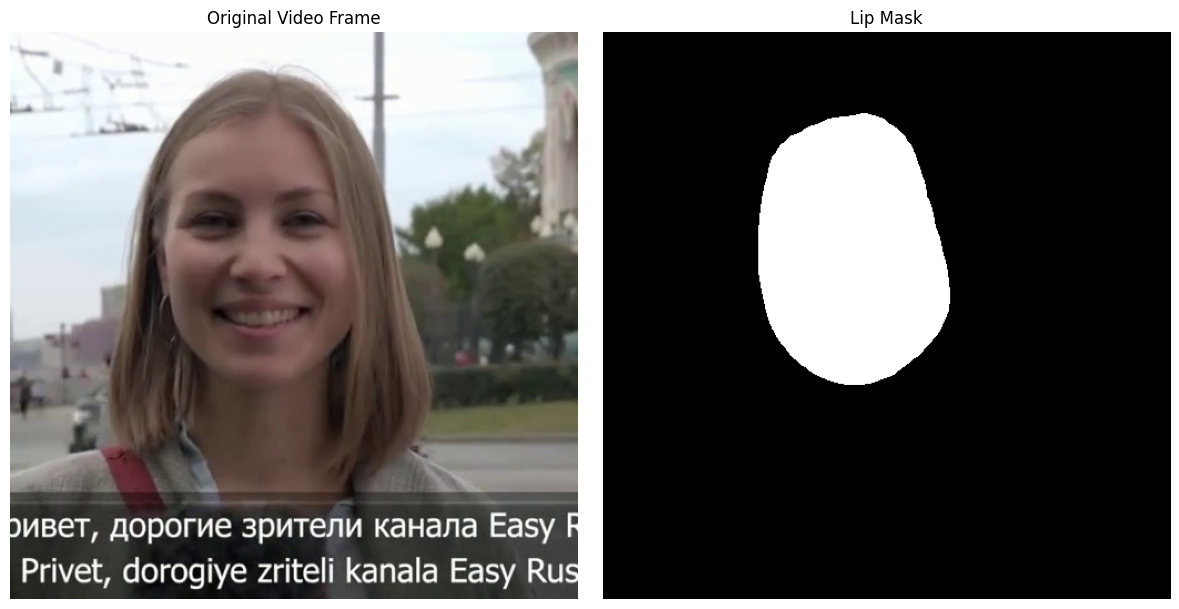

In [32]:
# Display lip mask, scaling to 255 for better visibility
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(frames[frame_idx].permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Original Video Frame')
axes[0].axis('off')

axes[1].imshow(masks[frame_idx]*255, cmap='gray')
axes[1].set_title('Lip Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()